In [1]:
# import everything we need
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import geopandas as gpd
import imageio
import os
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
# suppress warning because we want to change values in a copy of a df
import warnings
warnings.simplefilter(action="ignore", category=Warning)
pd.reset_option("all")

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



- #### First we want to read and split the data, and then we want to save the data in a DataFrame. Then we want to remove all duplicates of speakerid such that we have every speaker only once per Congress. 

In [3]:
# list with all names of files
names = ["097_SpeakerMap.txt","098_SpeakerMap.txt","099_SpeakerMap.txt","100_SpeakerMap.txt","101_SpeakerMap.txt",
        "102_SpeakerMap.txt","103_SpeakerMap.txt","104_SpeakerMap.txt","105_SpeakerMap.txt","106_SpeakerMap.txt",
         "107_SpeakerMap.txt","108_SpeakerMap.txt","109_SpeakerMap.txt","110_SpeakerMap.txt","111_SpeakerMap.txt",
         "112_SpeakerMap.txt","113_SpeakerMap.txt","114_SpeakerMap.txt"]

In [4]:
# column names
columns = ["speakerid","speech_id","lastname","firstname","chamber","state","gender","party","district","nonvoting"]

In [5]:
# make a list for all df
list_df = []
# open all files and store in df
for filename in names:
    # define path to files
    path = "DS_project/Us hein daily speaker map/"+filename
    with open(path) as file:
        # split at "|"
        spamreader = csv.reader(file, delimiter="|")
        # set column names
        df = pd.DataFrame(spamreader, columns = columns)
        # delete header row
        df = df[1:]
        # delete rows with duplicates of speaker id such that every speaker occurs only once in the df
        df_del = df.drop_duplicates(subset=["speakerid"])
        # append to list
        list_df.append(df_del)

In [6]:
# rename df according to year
df_97 = list_df[0]
df_98 = list_df[1]
df_99 = list_df[2]
df_100 = list_df[3]
df_101 = list_df[4]
df_102 = list_df[5]
df_103 = list_df[6]
df_104 = list_df[7]
df_105 = list_df[8]
df_106 = list_df[9]
df_107 = list_df[10]
df_108 = list_df[11]
df_109 = list_df[12]
df_110 = list_df[13]
df_111 = list_df[14]
df_112 = list_df[15]
df_113 = list_df[16]
df_114 = list_df[17]

- #### Now we want to make sub-DataFrames that only consisting of gender, chamber, state and party because we only need this data for the following analysis. In this way, everything goes faster in the follwoing steps because there is less data that we have to parse.

In [7]:
# make a sub df

df_97_part = df_97[["gender","chamber","state","party"]]
df_98_part = df_98[["gender","chamber","state","party"]]
df_99_part = df_99[["gender","chamber","state","party"]]
df_100_part = df_100[["gender","chamber","state","party"]]
df_101_part = df_101[["gender","chamber","state","party"]]
df_102_part = df_102[["gender","chamber","state","party"]]
df_103_part = df_103[["gender","chamber","state","party"]]
df_104_part = df_104[["gender","chamber","state","party"]]
df_105_part = df_105[["gender","chamber","state","party"]]
df_106_part = df_106[["gender","chamber","state","party"]]
df_107_part = df_107[["gender","chamber","state","party"]]
df_108_part = df_108[["gender","chamber","state","party"]]
df_109_part = df_109[["gender","chamber","state","party"]]
df_110_part = df_110[["gender","chamber","state","party"]]
df_111_part = df_111[["gender","chamber","state","party"]]
df_112_part = df_112[["gender","chamber","state","party"]]
df_113_part = df_113[["gender","chamber","state","party"]]
df_114_part = df_114[["gender","chamber","state","party"]]

# example
df_114_part.head()

,gender,chamber,state,party
1,F,H,WA,R
2,M,H,CA,D
3,M,H,KY,R
4,M,H,OK,R
5,F,H,CA,D


In [8]:
# list of all sub df
sub_df = [df_97_part,df_98_part,df_99_part,df_100_part,df_101_part,df_102_part,df_103_part,df_104_part,
          df_105_part,df_106_part,df_107_part,df_108_part,df_109_part,df_110_part,df_111_part,df_112_part,
          df_113_part,df_114_part]
# all congress numbers
number = [num for num in range(97,115)]

In [9]:
# which state is which region
midwest = ["ND","MN","SD","IA","NE","KS","MO","WI","IL","IN","MI","OH"]
west = ["NM","CO","ID","MT","NV","UT","WY","AK","CA","HI","OR","WA","AZ","AS","MP"]
northeast = ["ME","VT","NH","MA","CT","RI","NY","PA","NJ"]
south = ["TX","OK","AR","LA","MS","AL","FL","GA","TN","KY","SC","NC","VA","WV","VA","DC","DE","MD","GU","VI","PR"]

In [10]:
for congress in sub_df:
    reg = []
    for index, row in congress.iterrows():
        if row["state"] in midwest:
            reg.append("midwest")
        elif row["state"] in west:
            reg.append("west")
        elif row["state"] in northeast:
            reg.append("northeast")
        elif row["state"] in south:
            reg.append("south")
            
    congress["region"] = reg

In [11]:
# example
df_114_part.head()

,gender,chamber,state,party,region
1,F,H,WA,R,west
2,M,H,CA,D,west
3,M,H,KY,R,south
4,M,H,OK,R,south
5,F,H,CA,D,west


## Gender distribution of speakers in the Senate and House of Representatives

In [12]:
female_h = []
female_s = []
male_h =[]
male_s = []
total_per_year_h = []
total_per_year_s = []

# go through the sub df (df of every congress)
for elem in sub_df:
    # reset counter
    male_counter_h = 0
    male_counter_s = 0
    female_counter_h = 0
    female_counter_s = 0
    # go through rows
    # columns are gender, chamber, state, party, region
    for index, row in elem.iterrows():
        # house
        if row[1] == "H":
            # men
            if row[0] == "M":
                male_counter_h += 1
            # women
            elif row[0] == "F":
                female_counter_h += 1
        # senate
        elif row[1] == "S":
            if row[0] == "M":
                male_counter_s += 1
            # women
            elif row[0] == "F":
                female_counter_s += 1
    # append to according list
    male_h.append(male_counter_h)
    female_h.append(female_counter_h)
    male_s.append(male_counter_s)
    female_s.append(female_counter_s)
    # total per year is sum of male and female
    total_per_year_h.append(male_counter_h+female_counter_h)
    total_per_year_s.append(male_counter_s+female_counter_s)            

In [13]:
# calculate percentage of the genders for senate
percentage_per_year_male_s = [(male_s[i]/total_per_year_s[i])*100 for i,element in enumerate(male_s)]
percentage_per_year_female_s = [(female_s[i]/total_per_year_s[i])*100 for i,element in enumerate(female_s)]

# calculate percentage of the genders for house
percentage_per_year_male_h = [(male_h[i]/total_per_year_h[i])*100 for i,element in enumerate(male_h)]
percentage_per_year_female_h = [(female_h[i]/total_per_year_h[i])*100 for i,element in enumerate(female_h)]

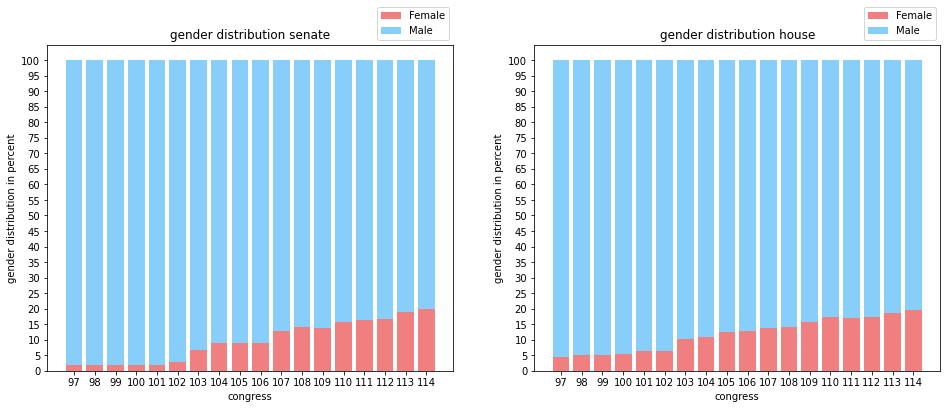

In [14]:
# plot the distribution over the years
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.bar(number,percentage_per_year_female_s,color="lightcoral",label="Female")
ax1.bar(number,percentage_per_year_male_s,color="lightskyblue",
        bottom=np.array(percentage_per_year_female_s),label="Male")
ax1.legend(loc="best",bbox_to_anchor=(0.8,1.0))
ax1.set_xticks(np.arange(97,115,1))
ax1.set_yticks(np.arange(0,105,5))
ax1.set_ylabel("gender distribution in percent")
ax1.set_xlabel("congress")
ax1.set_title("gender distribution senate")

ax2.bar(number,percentage_per_year_female_h,color="lightcoral",label="Female")
ax2.bar(number,percentage_per_year_male_h,color="lightskyblue",
        bottom=np.array(percentage_per_year_female_h),label="Male")
ax2.legend(loc="best",bbox_to_anchor=(0.8,1.0))
ax2.set_xticks(np.arange(97,115,1))
ax2.set_yticks(np.arange(0,105,5))
ax2.set_ylabel("gender distribution in percent")
ax2.set_xlabel("congress")
ax2.set_title("gender distribution house")
plt.show()

### Analysis:
We see a clear trend, both in the senate and the house, in the percentage of female speakers. The percentage of women in the Senate was even smaller than for the House in the 97th Congress (January 3, 1981 – January 3, 1983), and has increades to around 20% until the 114th Congress (January 3, 2015 – January 3, 2017).

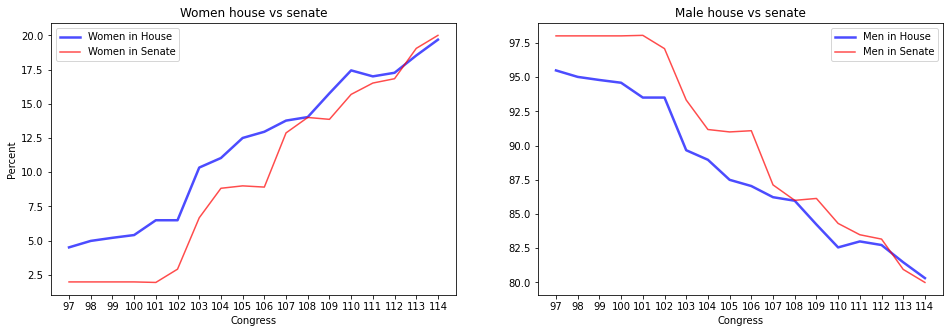

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
# make one line wider that we see both lines
ax1.plot(number, percentage_per_year_female_h, color="b", alpha = 0.7,linewidth = 2.5, label = "Women in House")
ax1.plot(number,percentage_per_year_female_s, color= "r", alpha = 0.7, label = "Women in Senate")
ax1.set_title("Women house vs senate")
ax1.set_ylabel("Percent")
ax1.set_xlabel("Congress")
ax1.legend(loc="best")
ax1.set_xticks(range(97,115,1))

ax2.plot(number, percentage_per_year_male_h, color = "b", alpha = 0.7, linewidth = 2.5,label = "Men in House")
ax2.plot(number, percentage_per_year_male_s, color = "r", alpha = 0.7, label = "Men in Senate")
ax2.set_title("Male house vs senate")
ax2.set_xlabel("Congress")
ax2.legend(loc="best")
ax2.set_xticks(range(97,115,1))
plt.show()

Here we can see again how the percentage of the genders differ for House and Senate.

In [16]:
# we look here only at the senate
female_overall = percentage_per_year_female_s
male_overall = percentage_per_year_male_s

# now we split the data set after 13 congresses for the test and training set
num_train = np.array(number[:-5]).reshape(-1,1)
num_test = np.array(number[-5:]).reshape(-1,1)
female_train = np.array(female_overall[:-5]).reshape(-1,1)
female_test = np.array(female_overall[-5:]).reshape(-1,1)
male_train = np.array(male_overall[:-5]).reshape(-1,1)
male_test = np.array(male_overall[-5:]).reshape(-1,1)

- #### Now we use linear regression to predict the speaker percentage of women/men in the Senate for the last 5 congresses of our data

Coefficients women: 
 [[1.18554938]]
Coefficient of determination women: 0.91

Coefficients men: 
 [[-1.18554938]]
Coefficient of determination men: 0.91


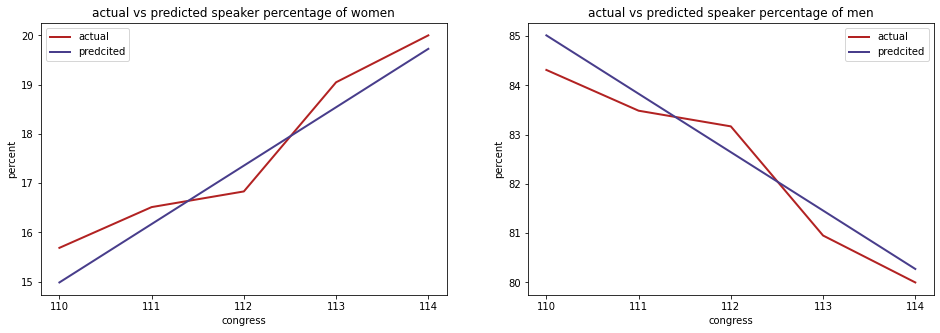

In [17]:
# predcit score of women
regr = LinearRegression()
regr.fit(num_train,female_train)
predicted_female= regr.predict(num_test)

# print the coefficients
print("Coefficients women: \n", regr.coef_)

# print the coefficient of determination where 1 would be a perfect prediction
print("Coefficient of determination women: %.2f" % r2_score(female_test, predicted_female))

# Plot the output
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(num_test, female_test, color="firebrick", linewidth= 2,label = "actual")
ax1.plot(num_test, predicted_female, color="darkslateblue", linewidth = 2, label = "predcited")
ax1.set_ylabel("percent")
ax1.set_xlabel("congress")
ax1.set_title("actual vs predicted speaker percentage of women")
ax1.set_xticks(np.arange(110,115,1))
ax1.legend()

# predict score of men
regr2 = LinearRegression()
regr2.fit(num_train,male_train)
predicted_male= regr2.predict(num_test)


# print the coefficients
print("\nCoefficients men: \n", regr2.coef_)

# print the coefficient of determination where 1 would be a perfect prediction
print("Coefficient of determination men: %.2f" % r2_score(male_test, predicted_male))
ax2.plot(num_test, male_test, color="firebrick", linewidth= 2,label = "actual")
ax2.plot(num_test, predicted_male, color="darkslateblue", linewidth = 2, label = "predcited")
ax2.set_ylabel("percent")
ax2.set_xlabel("congress")
ax2.set_title("actual vs predicted speaker percentage of men")
ax2.set_xticks(np.arange(110,115,1))
ax2.legend()

plt.show()

The model predicted the trend correctly. The values are sometimes a little too small and sometimes to big. In reality, the steepness of the ascent/descent varies slightly over time. But for that, the model predicted the data pretty well with less than 1 percent difference.

- #### Now we want to predict how the ratio could be in future

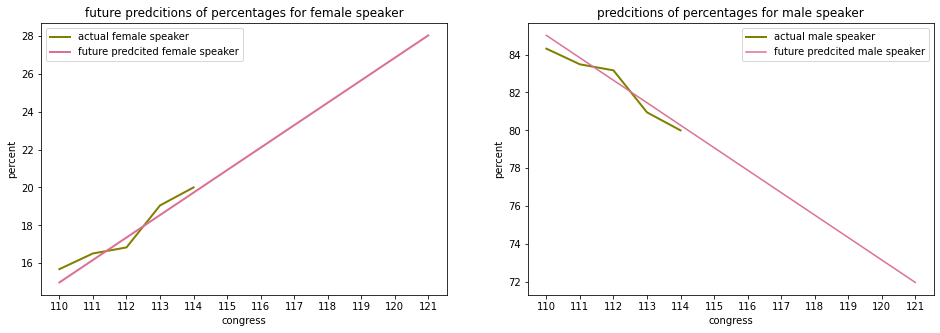

In [18]:
# make an array with future values to predict the future
num_test_future = np.array([num for num in range(110,122)]).reshape(-1,1)
predicted_male_future= regr2.predict(num_test_future)
predicted_female_future = regr.predict(num_test_future)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
# plot women
ax1.plot(num_test, female_test, color="olive", linewidth= 2,label = "actual female speaker")
ax1.plot(num_test_future,predicted_female_future, linewidth = 2, color = "palevioletred", label = "future predcited female speaker")
ax1.set_ylabel("percent")
ax1.set_xlabel("congress")
ax1.set_title("future predcitions of percentages for female speaker")
ax1.set_xticks(np.arange(110,122,1))
ax1.legend()

# plot men
ax2.plot(num_test, male_test, color="olive", linewidth= 2,label = "actual male speaker")
ax2.plot(num_test_future,predicted_male_future, color = "palevioletred", label = "future predcited male speaker")
ax2.set_ylabel("percent")
ax2.set_xlabel("congress")
ax2.set_title("predcitions of percentages for male speaker")
ax2.set_xticks(np.arange(110,122,1))
ax2.legend()
plt.show()

### Analysis:
We see a clear trend our the data. The proportion of female speakers in the Seante increases over the course of the Congresses. After the 102nd Congress (January 3, 1991 - January 3, 1993) there is a strong change in this direction. The proportion of female speakers is increasing drastically. From the 102nd to the 103rd Congress the percentage has more than doubled itself%. In the male data we can see the opposite effect, but this obvious because the values are dependent of each other. There is a visible decrease in male speakers after the 102nd Congress. The trend is that the percentage of male speakers will continue to decrease in the future, while the percentage of female speakers will increase. We also see that in our predictions. But as said before, the steepness varies in reality a lot. So it is possible, that the percentage stagnate, but it is also possible that the percentage in-/decreases reapily from one Congress to the next. 

## Party distribution of speakers in the Senate and House of Representatives

- #### Now we want to analyse the party distribution of the speakers and how the distribution changed

In [19]:
# make a function to count the speakers per party
def counter_party(dataframe):
    sub_df = dataframe
    dem_house = []
    rep_house = []
    dem_sen = []
    rep_sen = []
    other_sen = []
    other_house = []
    total_party_h = []
    total_party_s = []

    for elem in sub_df:
        d_h = 0
        d_s = 0
        r_h = 0
        r_s = 0
        other_h = 0
        other_s = 0
        
        # columns are gender, chamber, state, party, region
        for index, row in elem.iterrows():
            if row[-2] == "D":
                if row[1] == "H":
                    d_h += 1
                elif row[1] == "S":
                    d_s += 1
        
            elif row[-2] == "R":
                if row[1] == "H":
                    r_h += 1
                elif row[1] == "S":
                    r_s += 1
                   
            else:
                if row[1] == "H":
                    other_h += 1
                elif row[1] == "s":
                    other_s += 1 
                    
        dem_house.append(d_h)
        rep_house.append(r_h)
        dem_sen.append(d_s)
        rep_sen.append(r_s)
        other_house.append(other_h)
        other_sen.append(other_s)
        total_party_h.append(d_h+r_h+other_h)
        total_party_s.append(d_s+r_s+other_s)  
        
    return {"dem_house":dem_house,"rep_house":rep_house,"other_house": other_house, 
            "total_party_h": total_party_h, "dem_sen": dem_sen, "rep_sen": rep_sen,
            "other_sen": other_sen, "total_party_s":total_party_s}

In [20]:
party_sub = counter_party(sub_df)

# get the percentage per year
percentage_per_year_dem_s = [(party_sub["dem_sen"][i]/party_sub["total_party_s"][i])*100 for 
                             i,element in enumerate(party_sub["dem_sen"])]
percentage_per_year_rep_s = [(party_sub["rep_sen"][i]/party_sub["total_party_s"][i])*100 for 
                             i,element in enumerate(party_sub["rep_sen"])]
percentage_per_year_other_s = [(party_sub["other_sen"][i]/party_sub["total_party_s"][i])*100 for 
                               i,element in enumerate(party_sub["other_sen"])]

percentage_per_year_dem_h = [(party_sub["dem_house"][i]/party_sub["total_party_h"][i])*100 for 
                             i,element in enumerate(party_sub["dem_house"])]
percentage_per_year_rep_h = [(party_sub["rep_house"][i]/party_sub["total_party_h"][i])*100 for 
                             i,element in enumerate(party_sub["rep_house"])]
percentage_per_year_other_h = [(party_sub["other_house"][i]/party_sub["total_party_h"][i])*100 for 
                               i,element in enumerate(party_sub["other_house"])]              
                              

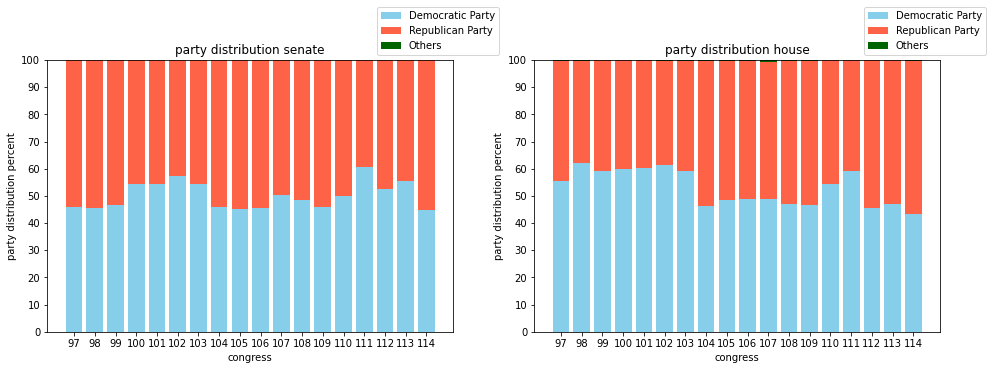

In [21]:
# plot party distribution senate
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.bar(number,percentage_per_year_dem_s,color="skyblue",label="Democratic Party")
ax1.bar(number,percentage_per_year_rep_s,color="tomato",bottom=np.array(percentage_per_year_dem_s),
        label="Republican Party")
ax1.bar(number,percentage_per_year_other_s,color="darkgreen",
        bottom=np.array(percentage_per_year_dem_s)+np.array(percentage_per_year_rep_s),label="Others")
ax1.set_xticks(np.arange(97,115,1))
ax1.set_yticks(np.arange(0,110,10))
ax1.set_ylabel("party distribution percent")
ax1.set_xlabel("congress")
ax1.set_title("party distribution senate")
ax1.legend(loc="best",bbox_to_anchor=(0.8,1.0))

# plot party distribution house
ax2.bar(number,percentage_per_year_dem_h,color="skyblue",label="Democratic Party")
ax2.bar(number,percentage_per_year_rep_h,color="tomato",bottom=np.array(percentage_per_year_dem_h),
        label="Republican Party")
ax2.bar(number,percentage_per_year_other_h,color="darkgreen",
        bottom=np.array(percentage_per_year_dem_h)+np.array(percentage_per_year_rep_h),label="Others")
ax2.legend(loc="best",bbox_to_anchor=(0.8,1.0))
ax2.set_xticks(np.arange(97,115,1))
ax2.set_yticks(np.arange(0,110,10))
ax2.set_ylabel("party distribution percent")
ax2.set_xlabel("congress")
ax2.set_title("party distribution house")
plt.show()

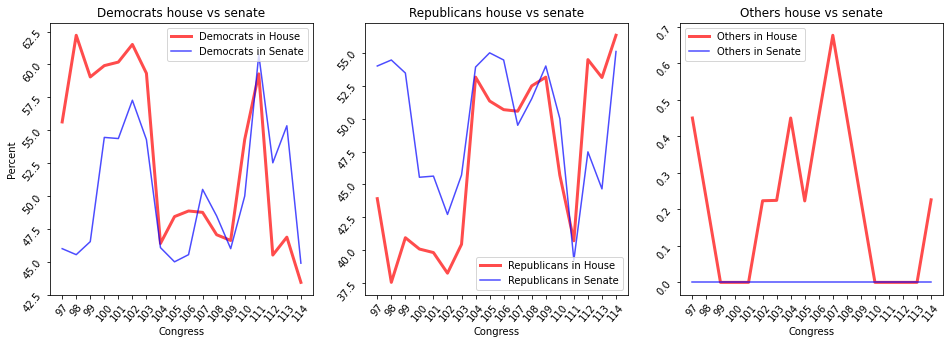

In [22]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
# make the first line wider that it is still visible when both lines are at the same place in plot
ax1.plot(number, percentage_per_year_dem_h, color="red", alpha = 0.7,linewidth = 3, label = "Democrats in House")
ax1.plot(number,percentage_per_year_dem_s, color= "blue", alpha = 0.7, label = "Democrats in Senate")
ax1.set_title("Democrats house vs senate")
ax1.set_ylabel("Percent")
ax1.set_xlabel("Congress")
ax1.legend(loc="best")
ax1.set_xticks(range(97,115,1))
ax1.tick_params(labelrotation=50)

ax2.plot(number, percentage_per_year_rep_h, color = "red", alpha = 0.7, linewidth = 3, label = "Republicans in House")
ax2.plot(number, percentage_per_year_rep_s, color = "blue", alpha = 0.7, label = "Republicans in Senate")
ax2.set_title("Republicans house vs senate")
ax2.set_xlabel("Congress")
ax2.legend(loc="best")
ax2.set_xticks(range(97,115,1))
ax2.tick_params(labelrotation=50)

ax3.plot(number,percentage_per_year_other_h, color= "red", alpha = 0.7, linewidth = 3,label = "Others in House")
ax3.plot(number,percentage_per_year_other_s, color= "blue", alpha = 0.7, label = "Others in Senate")
ax3.set_title("Others house vs senate")
ax3.set_xlabel("Congress")
ax3.legend(loc="best")
ax3.set_xticks(range(97,115,1))
ax3.tick_params(labelrotation=50)
plt.show()

We can see that the distributions of the parties differ in the House and the Senate and there are barely any speakers of an other party in the Seante.

In [23]:
# we only look at the house
rep_total = percentage_per_year_rep_h
dem_total = percentage_per_year_dem_h
other_total = percentage_per_year_other_h

In [24]:
# make test and training sets
rep_train = np.array(rep_total[:-5]).reshape(-1,1)
rep_test = np.array(rep_total[-5:]).reshape(-1,1)
dem_train = np.array(dem_total[:-5]).reshape(-1,1)
dem_test = np.array(dem_total[-5:]).reshape(-1,1)
other_train = np.array(other_total[:-5]).reshape(-1,1)
other_test = np.array(other_total[-5:]).reshape(-1,1)

- #### We use linear regression to predict the values for the party distribution among the speakers

In [25]:
# prediction for republicans
regr_rep = LinearRegression()
regr_rep.fit(num_train,rep_train)
predicted_rep = regr_rep.predict(num_test)

# predictions for democrats
regr_dem = LinearRegression()
regr_dem.fit(num_train,dem_train)
predicted_dem = regr_dem.predict(num_test)

# predictions for others
regr_ot = LinearRegression()
regr_ot.fit(num_train,other_train)
predicted_ot = regr_ot.predict(num_test)

# print the coefficients
print("Coefficients Republicans: \n", regr_rep.coef_)
print("\nCoefficients Democrats: \n", regr_dem.coef_)
print("\nCoefficients Others: \n", regr_ot.coef_)

# print the coefficient of determination where 1 would be a perfect prediction
print("\n\nCoefficient of determination Republicans: %.2f" % r2_score(rep_test, predicted_rep))
print("\nCoefficient of determination Democrats: %.2f" % r2_score(dem_test, predicted_dem))
print("\nCoefficient of determination Others: %.2f" % r2_score(other_test, predicted_ot))


Coefficients Republicans: 
 [[1.30896861]]

Coefficients Democrats: 
 [[-1.33383386]]

Coefficients Others: 
 [[0.02486525]]


Coefficient of determination Republicans: -1.11

Coefficient of determination Democrats: -1.27

Coefficient of determination Others: -25.00


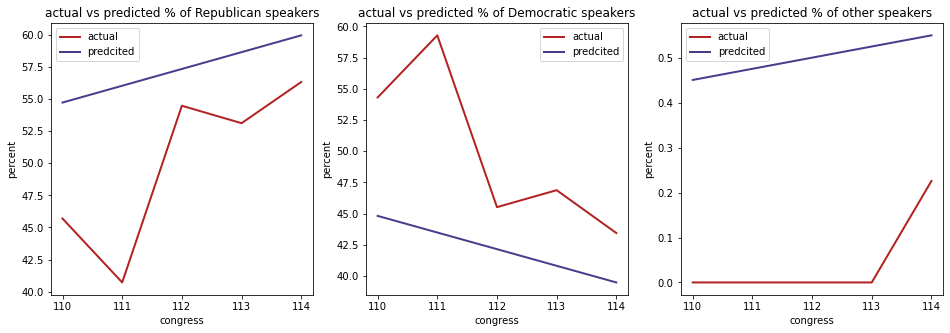

In [26]:
# Plot the output
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
# republicans
ax1.plot(num_test, rep_test, color="firebrick", linewidth= 2,label = "actual")
ax1.plot(num_test, predicted_rep, color="darkslateblue", linewidth = 2, label = "predcited")
ax1.set_ylabel("percent")
ax1.set_xlabel("congress")
ax1.set_title("actual vs predicted % of Republican speakers")
ax1.set_xticks(np.arange(110,115,1))
ax1.legend(loc="best")

# democrats
ax2.plot(num_test, dem_test, color="firebrick", linewidth= 2,label = "actual")
ax2.plot(num_test, predicted_dem, color="darkslateblue", linewidth = 2, label = "predcited")
ax2.set_ylabel("percent")
ax2.set_xlabel("congress")
ax2.set_title("actual vs predicted % of Democratic speakers")
ax2.set_xticks(np.arange(110,115,1))
ax2.legend(loc="best")

# others
ax3.plot(num_test, other_test, color="firebrick", linewidth= 2,label = "actual")
ax3.plot(num_test, predicted_ot, color="darkslateblue", linewidth = 2, label = "predcited")
ax3.set_ylabel("percent")
ax3.set_xlabel("congress")
ax3.set_title("actual vs predicted % of other speakers")
ax3.set_xticks(np.arange(110,115,1))
ax3.legend(loc="best")

plt.show()

### Analysis:
The trend for the speakers seems to tend towards more Republican speakers and fewer Democratic speakers. The percentage of other speakers is negligibly small (under 1 percent). Our model predicts a steady increase in other speakers. And thus the value would be much higher than it actually is. There was a sudden increase in the 113th Congress. If this continued, our model would be very wrong as it predicts a flatter rise. But it can also happen that the other speaker decrease again from one Congress to the next or disappears completely.

For the Republican and Democratic speakers, the model recognized the overall trend. What the model did not see coming was that there was the big increase in Democratic speakers in the 111th Congress. This might be caused by the ending presidency of George W. Bush (Republican Party) and the starting presidency of Barack Obama (Democratic Party). But overall, the trend of a decreasing percentage of Democratic speakers continued. The linear regression model predicted it as well. But the real decrease is steeper and faster and varies more every Congress as we can see from the numerous spikes that happen instead of a linear de-/increase. 

- #### Now we want to see how the trend looks for the future Congresses

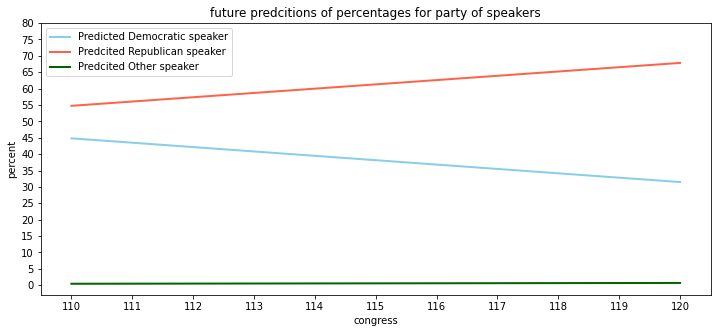

In [27]:
# future predictions
num_future = np.array([num for num in range(110,121)]).reshape(-1,1)

predicted_dem_future= regr_dem.predict(num_future)
predicted_rep_future = regr_rep.predict(num_future)
predicted_other_future = regr_ot.predict(num_future)

plt.figure(figsize=(12,5))
plt.plot(num_future, predicted_dem_future, color="skyblue", linewidth = 2, label = "Predicted Democratic speaker")
plt.plot(num_future, predicted_rep_future, color="tomato", linewidth = 2, label = "Predcited Republican speaker")
plt.plot(num_future,predicted_other_future, color = "darkgreen", linewidth = 2, label = "Predcited Other speaker")
plt.ylabel("percent")
plt.xlabel("congress")
plt.title("future predcitions of percentages for party of speakers")
plt.xticks(np.arange(110,121,1))
plt.yticks(np.arange(0,81,5))
plt.legend()
plt.show()

### Prediction:
The prediction is that if there is no major event happening that would change everything, the distribution of the parties will move further away from each other. But in reality this change is not probable in this extent. It is more likely that there will be changes that go in the other direction, so that the distributions will converge again. Because there will be changes of president or other external influences on politics, which will change the proportion. So, a party's exact percentage for future Congresses is probably not predictable without considering external influences

## Hypothesis testing

- #### Now we want to check our hypothesis that the parties are more or less equally distributed or if there is a significance deviation

### Hypothesis:

H0: The percentage of Democratic speakers = 50

H1: The percentage of Democratic speakers ≠ 50

### Test statistic
- x_bar = sample mean
- mu = the population mean
- s = sample standard deviation
- n = the number of observations


- significance level α = 0.05 (5%)

In [28]:
# n = lenght of dem_total
n = len(dem_total)

In [29]:
x_bar = sum(dem_total)/len(dem_total)

In [30]:
mu = 50

In [31]:
s = np.std(dem_total)

### Formula for the test statistic (ts):

$$
\frac{xbar -mu}{s} * \sqrt n
$$


In [32]:
ts = ((x_bar - mu)/s)*(n)**(1/2)

- find P_value of the ts
- if P_value is smaller than the significance level, we reject $ H_0 $
- this is a two-tailed test -> we need to find the P-value of a T-value bigger than ts and multiply by 2
- degrees of freedom = n-1

In [33]:
p_val = 2*(1-stats.t.cdf(ts, n-1))
p_val

0.06660634667251197

### Conclusion:
Our p_value is bigger than our significance level, thus we fail to reject the null hypothesis at an error rate of 5%. This means that the distribution of the speakers are more or less equally divided by parties.

## Gender distribution of speakers per party

- #### Now we want to look at the distribution of the genders per party

Because there are so few other speakers (speakers not from Democratic or Republican Party), we only look at the two big parties for this analysis.

In [34]:
# look at total numbers (house and senate)
female_d = []
female_r = []
male_d =[]
male_r = []
total_d = []
total_r = []
# go through the sub df (df of every year)
for elem in sub_df:
    tot_d = 0
    tot_r = 0
    male_counter_d = 0
    male_counter_r = 0
    female_counter_d = 0
    female_counter_r = 0
    # look at the entries in the party column
    for index, row in elem.iterrows():
        if row[-2] == "D":
            tot_d += 1
            # look at gender column
            if row[0] == "M":
                male_counter_d += 1
            elif row[0] == "F":
                female_counter_d += 1
        elif row[-2] == "R":
            tot_d += 1
            # look at gender column
            if row[0] == "M":
                male_counter_r += 1
            elif row[0] == "F":
                female_counter_r += 1
                
                
    # append to according list
    total_d.append(tot_d)
    total_r.append(tot_r)
    male_d.append(male_counter_d)
    female_d.append(female_counter_d)
    male_r.append(male_counter_r)
    female_r.append(female_counter_r)

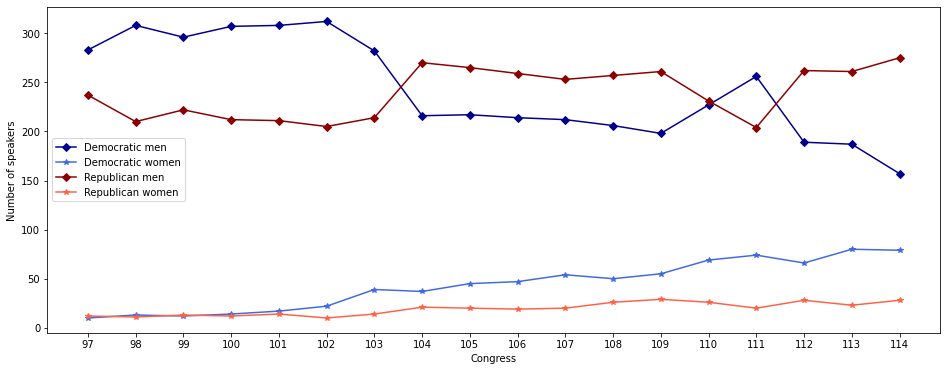

In [35]:
plt.figure(figsize=(16,6))
plt.plot(number,male_d, c = "darkblue", marker = "D", label = "Democratic men")
plt.plot(number,female_d, c = "royalblue", marker = "*", label = "Democratic women")
plt.plot(number,male_r, c = "darkred", marker = "D", label = "Republican men")
plt.plot(number,female_r, c = "tomato", marker = "*", label = "Republican women")
plt.xticks(np.arange(97,115,1))
plt.xlabel("Congress")
plt.ylabel("Number of speakers")
plt.legend(loc = "best")
plt.show()

### Analysis:
The number of female speakers starts to increase at the 102nd Congress. For the male speakers, it changes which party has more male speakers. But for the female speakers we see that both increase, but there are always more female Democrats than Republicans.

- #### Now we want to see the distribution of the sum of female and male speakers per party over these Congresses 

In [36]:
sum_d_m = 0
sum_d_f = 0
for el in male_d:
    sum_d_m += el
for el in female_d:
    sum_d_f += el
    
sum_r_m = 0
sum_r_f = 0
for el in male_r:
    sum_r_m += el
for el in female_r:
    sum_r_f += el

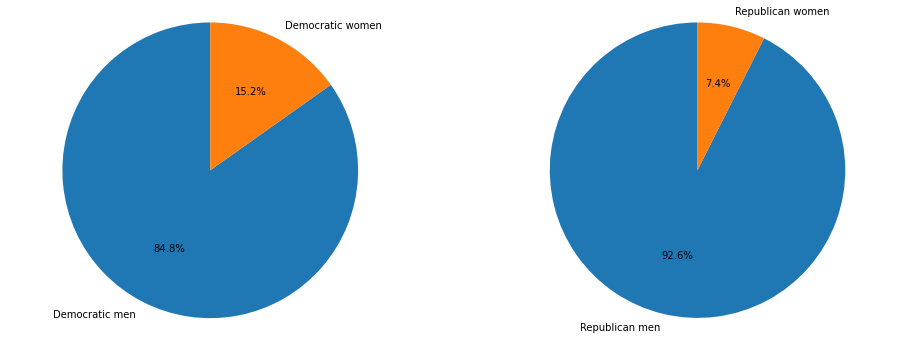

In [37]:
labels_d = "Democratic men", "Democratic women"
sizes_d = [(sum_d_m/(sum_d_f+sum_d_m)), (sum_d_f/(sum_d_f+sum_d_m))]

labels_r = "Republican men", "Republican women"
sizes_r = [(sum_r_m/(sum_r_f+sum_r_m)), (sum_r_f/(sum_r_f+sum_r_m))]

fig1, (ax1,ax2) = plt.subplots(1,2,figsize = (16,6))
ax1.pie(sizes_d, labels=labels_d, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
ax2.pie(sizes_r, labels=labels_r, autopct='%1.1f%%', startangle=90)
ax2.axis('equal')
plt.show()

We can see that over all Congresses that were in our data, the proportion of female to male speakers is higher for the Democrats. This is what we expected after previous analysis.

## Analysis of geographic data

- #### Now we look at the geographical information of the speakers

Data taken from GitHub (https://github.com/joncutrer/geopandas-tutorial/tree/master/data; 24.04.22, 16:18)

For this analysis we use the data "usa-states-census-2014.shp"

In [38]:
# read the data
states = gpd.read_file("gpd_data/data/usa-states-census-2014.shp")

In [39]:
# function to get the geographical data
def party_state(data):
    df = pd.DataFrame(data)
    # read file anew to reset
    states = gpd.read_file("gpd_data/data/usa-states-census-2014.shp")
    # counter for democrats
    states["data_d"] = 0
    states["counter_total"] = 0
    states["percent_d"] = 0
    # go through df
    for index, row in df.iterrows():
        where = row["state"]
        # because there are so little other party we only look at democtras and republicans
        # if it is another party we ignore it
        if row["party"] == "D":
            states.loc[states["STUSPS"] == where, "data_d"] += 1
            states.loc[states["STUSPS"] == where, "counter_total"] += 1   
        elif row["party"] == "R":
             states.loc[states["STUSPS"] == where, "counter_total"] += 1   
                
    # get the percentage of democrats  
    for line in states:
        states["percent_d"] = 100 -((states["data_d"]/states["counter_total"])*100)
    return states

- #### We want to produce images of the colorcoded US map

In [40]:
images = []
numb =[num for num in range(97,115)]
def party_picture(data):
    global numb
    fig,ax = plt.subplots(1, figsize=(25,15),constrained_layout=True) 
    
    data.apply(lambda x: ax.annotate(text=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', 
                                     fontsize=14),axis=1);
    data.boundary.plot(ax=ax, color='Black', linewidth=.4)
    # republicans red, democrats blue, if it is neutral then it it greyish
    data.plot(ax=ax, column=data["percent_d"],cmap = "coolwarm", figsize=(12, 12),legend=True)
    title = "map "+str(numb[0])
    ax.text(-120, 28, title, bbox=dict(facecolor="white", alpha=1),size= "30")
    filepath = os.path.join("pictures_party_map/"+str(numb[0])+".jpg")
    numb = numb[1:]
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300)
    images.append(imageio.imread(filepath))
    plt.close(chart)

In [41]:
# save the images
def picture(data):
    for year in data:
        fig = party_picture(party_state(year))
picture(sub_df)

- #### To better show the change over time, we make a gif from the individual images

In [42]:
# save pictures as gif
imageio.mimsave('gif/us_party.gif', images, duration=1.2)

## Analysis:
As we can see, the geographical distribution of the parties changed. But there are also states that do not change much, for example Wyoming, which stayed a very Republican region over all these Congresses. Vermont was around the 97th Congress reddish, which means a more Republican state, and around the 102nd Congress it became a neutral state. Then at the 107th Congress, Vermont turned into a Democratic state based on the speakers. 
All in all, we can also observe a change. While in the 97th Congress the map was more neutral to blueish in color, and then from the 104th Congress on, it redder, which means that more Republican speakers spread out. Towards the 114th Congress, a large part of the map is reddish to very red, meaning very Republican dominated. This equals our prediction, that there is a larger percentage of Republican speakers in the later Congresses. 

- #### Lets see if we can predict a speaker’s party affiliation based on their geographic data. For this we want to verify if there is a correlation between a speaker's state and it's party.

For this we use Pearson’s Correlation. The coefficient scores are between -1 and 1, whereas -1 stands for a perfectly negatively correlated and 1 for perfectly positively correlated variable. Values below -0.5 or above 0.5 indicates a notable correlation, other values indicate a less notable correaltion. 

- #### Now we make numeric values out of the states and the parties

In [43]:
df_97_part["party"] = pd.factorize(df_97_part["party"])[0]
df_97_part["state"] = pd.factorize(df_97_part["state"])[0]

df_98_part["party"] = pd.factorize(df_98_part["party"])[0]
df_98_part["state"] = pd.factorize(df_98_part["state"])[0]

df_99_part["party"] = pd.factorize(df_99_part["party"])[0]
df_99_part["state"] = pd.factorize(df_99_part["state"])[0]

df_100_part["party"] = pd.factorize(df_100_part["party"])[0]
df_100_part["state"] = pd.factorize(df_100_part["state"])[0]

df_101_part["party"] = pd.factorize(df_101_part["party"])[0]
df_101_part["state"] = pd.factorize(df_101_part["state"])[0]

df_102_part["party"] = pd.factorize(df_102_part["party"])[0]
df_102_part["state"] = pd.factorize(df_102_part["state"])[0]

df_103_part["party"] = pd.factorize(df_103_part["party"])[0]
df_103_part["state"] = pd.factorize(df_103_part["state"])[0]

df_104_part["party"] = pd.factorize(df_104_part["party"])[0]
df_104_part["state"] = pd.factorize(df_104_part["state"])[0]

df_105_part["party"] = pd.factorize(df_105_part["party"])[0]
df_105_part["state"] = pd.factorize(df_105_part["state"])[0]

df_106_part["party"] = pd.factorize(df_106_part["party"])[0]
df_106_part["state"] = pd.factorize(df_106_part["state"])[0]

df_107_part["party"] = pd.factorize(df_107_part["party"])[0]
df_107_part["state"] = pd.factorize(df_107_part["state"])[0]

df_108_part["party"] = pd.factorize(df_108_part["party"])[0]
df_108_part["state"] = pd.factorize(df_108_part["state"])[0]

df_109_part["party"] = pd.factorize(df_109_part["party"])[0]
df_109_part["state"] = pd.factorize(df_109_part["state"])[0]

df_110_part["party"] = pd.factorize(df_110_part["party"])[0]
df_110_part["state"] = pd.factorize(df_110_part["state"])[0]

df_111_part["party"] = pd.factorize(df_111_part["party"])[0]
df_111_part["state"] = pd.factorize(df_111_part["state"])[0]

df_112_part["party"] = pd.factorize(df_112_part["party"])[0]
df_112_part["state"] = pd.factorize(df_112_part["state"])[0]

df_113_part["party"] = pd.factorize(df_113_part["party"])[0]
df_113_part["state"] = pd.factorize(df_113_part["state"])[0]

df_114_part["party"] = pd.factorize(df_114_part["party"])[0]
df_114_part["state"] = pd.factorize(df_114_part["state"])[0]

In [44]:
# calculate Pearson’s Correlation for each df
corr_list = []
for index, congress in enumerate(sub_df):
    corr, _ = pearsonr(congress["party"], congress["state"])
    corr_list.append(corr)

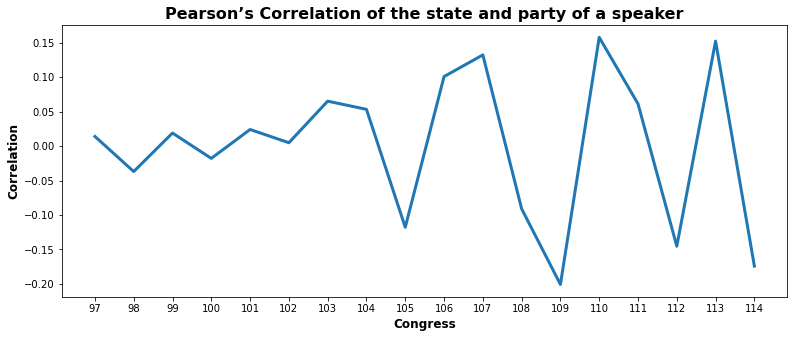

In [45]:
plt.figure(figsize=(13,5))
plt.plot(number,corr_list, linewidth=3)
plt.xticks(range(97,115,1))
plt.xlabel("Congress",fontsize=12,fontweight="bold")
plt.ylabel("Correlation",fontsize=12,fontweight="bold")
plt.title("Pearson’s Correlation of the state and party of a speaker",fontsize=16,fontweight="bold")
plt.show()

The values of the are all spaced around 0, in a range from -0.2 to 0.15 which means that there is not a notable correlation between the state and the party of a speaker. No Congress has a value in a range where the result would indicate a noticable correlation, thus we cannot use the state of a speaker to make predictions for the party of a speaker or vice versa. 

In [46]:
# calculate Pearson’s Correlation for each df
corr_list_west = []
corr_list_midwest = []
corr_list_south = []
corr_list_northeast = []

for index, congress in enumerate(sub_df):    
    # west
    data = []
    # midwest
    data_2 = []
    # south
    data_3 = []
    # northeast
    data_4 = []
    for i,e in congress.iterrows():
        if e["region"] == "west":
            data.append(e)
        elif e["region"] == "midwest":
            data_2.append(e)
        elif e["region"] == "south":
            data_3.append(e)
        elif e["region"] == "northeast":
            data_4.append(e)
            
    col = ["gender","chamber","state","party","region"]
    df = pd.DataFrame(data, columns = col)
    df_2 = pd.DataFrame(data_2, columns = col)
    df_3 = pd.DataFrame(data_3, columns = col)
    df_4 = pd.DataFrame(data_4, columns = col)
    
    corr, _ = pearsonr(df["party"], df["state"])
    corr_list_west.append(corr)
    
    corr2, _2 = pearsonr(df_2["party"], df_2["state"])
    corr_list_midwest.append(corr2)

    corr3, _3 = pearsonr(df_3["party"], df_3["state"])
    corr_list_south.append(corr3)
    
    corr4, _4 = pearsonr(df_4["party"], df_4["state"])
    corr_list_northeast.append(corr4)

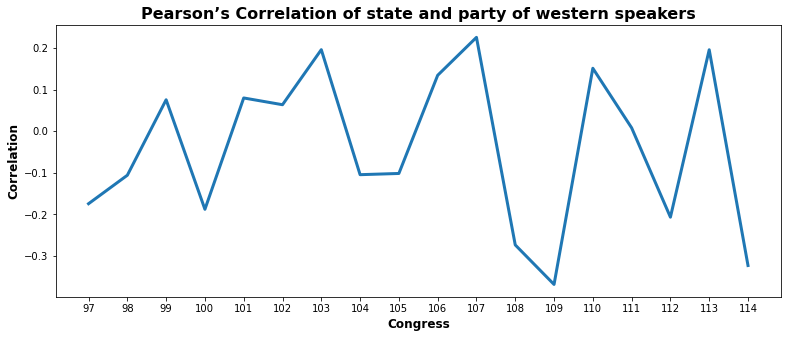

In [47]:
plt.figure(figsize=(13,5))
plt.plot(number,corr_list_west, linewidth=3)
plt.xticks(range(97,115,1))
plt.xlabel("Congress",fontsize=12,fontweight="bold")
plt.ylabel("Correlation",fontsize=12,fontweight="bold")
plt.title("Pearson’s Correlation of state and party of western speakers",fontsize=16,fontweight="bold")
plt.show()

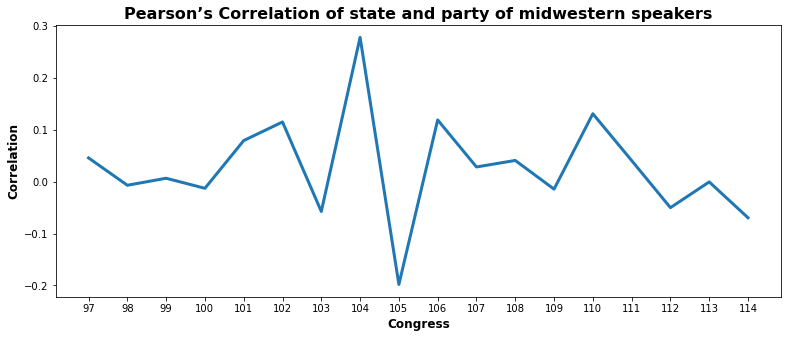

In [48]:
plt.figure(figsize=(13,5))
plt.plot(number,corr_list_midwest, linewidth=3)
plt.xticks(range(97,115,1))
plt.xlabel("Congress",fontsize=12,fontweight="bold")
plt.ylabel("Correlation",fontsize=12,fontweight="bold")
plt.title("Pearson’s Correlation of state and party of midwestern speakers",fontsize=16,fontweight="bold")
plt.show()

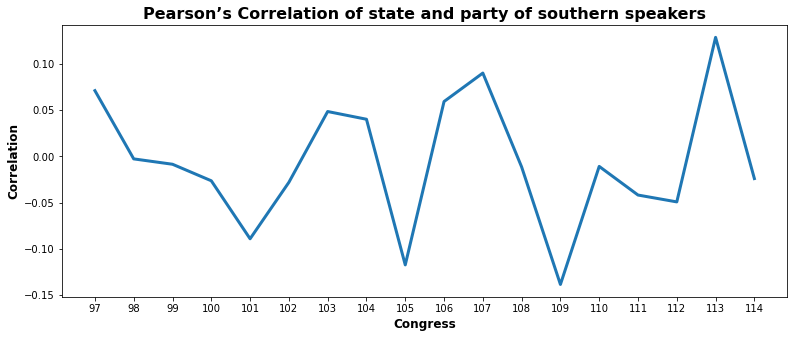

In [49]:
plt.figure(figsize=(13,5))
plt.plot(number,corr_list_south, linewidth=3)
plt.xticks(range(97,115,1))
plt.xlabel("Congress",fontsize=12,fontweight="bold")
plt.ylabel("Correlation",fontsize=12,fontweight="bold")
plt.title("Pearson’s Correlation of state and party of southern speakers",fontsize=16,fontweight="bold")
plt.show()

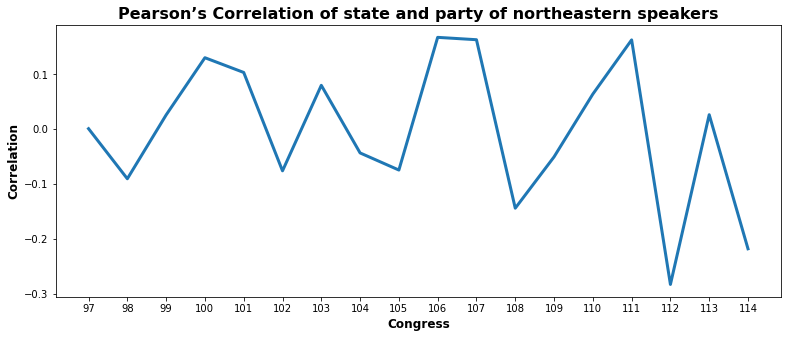

In [50]:
plt.figure(figsize=(13,5))
plt.plot(number,corr_list_northeast, linewidth=3)
plt.xticks(range(97,115,1))
plt.xlabel("Congress",fontsize=12,fontweight="bold")
plt.ylabel("Correlation",fontsize=12,fontweight="bold")
plt.title("Pearson’s Correlation of state and party of northeastern speakers",fontsize=16,fontweight="bold")
plt.show()

The plots of the Pearson's Correlation for the regions inidcate that the chance of predicting a speakers party from it's state and vice versa is the most likely in western states. Because in the western region, the value of the correlation is higher for more Congresses. In the midwestern states, there is a higher peak at the 104th Congress, but else, the value is not that high. For the southern and northeastern states, the value lies in a smaller range for all the Congresses with some peaks in the negative range at some points. But all in all, it is visible that even for a certain region, there cannot be made a prediction of a speakers party by the state and vice versa. 